In [ ]:
##get_ipython().kernel.do_shutdown(restart=True)       # Tor Restart the Kernal explicitly
!nvidia-smi  # this should display information about available GPUs
!pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com
import cudf  # this should work without any errors
!pip install plotly-express
%load_ext cudf.pandas

In [ ]:
import os

base_dir = '/kaggle/input/handwriting-recognition'
train_images_dir = os.path.join(base_dir, 'train_v2/train')
validation_images_dir = os.path.join(base_dir, 'validation_v2/validation')
test_images_dir = os.path.join(base_dir, 'test_v2/test')

# **Importing Libraries**


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report

In [ ]:
train_csv = pd.read_csv(os.path.join(base_dir, 'written_name_train_v2.csv'))
validation_csv = pd.read_csv(os.path.join(base_dir, 'written_name_validation_v2.csv'))
test_csv = pd.read_csv(os.path.join(base_dir, 'written_name_test_v2.csv'))

In [ ]:
train_csv.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [ ]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [ ]:
# There are 565 null samples
print("Number of null values in train_csv: \n",train_csv.isnull().sum())
print('\n---------------\n')
print("Number of null values in validation_csv: \n",validation_csv.isnull().sum())
print('\n---------------\n')
print("Number of null values in test_csv: \n",test_csv.isnull().sum())

Number of null values in train_csv: 
 FILENAME      0
IDENTITY    565
dtype: int64

---------------

Number of null values in validation_csv: 
 FILENAME     0
IDENTITY    78
dtype: int64

---------------

Number of null values in test_csv: 
 FILENAME     0
IDENTITY    70
dtype: int64


# ***Data Cleansing***

In [ ]:
# Drop null samples
train_csv = train_csv.dropna()
validation_csv = validation_csv.dropna()
test_csv = test_csv.dropna()

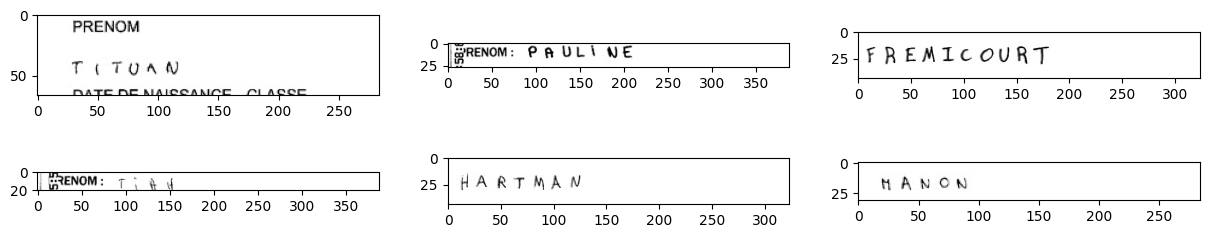

In [ ]:
# Plot unreadable image samples from train data
unreadable_indexes = train_csv[train_csv['IDENTITY'] == 'UNREADABLE'].index

plt.figure(figsize = (15,3))

offset = 10
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    image_name = train_csv.iloc[unreadable_indexes[i + offset],0]
    image = cv2.imread(os.path.join(train_images_dir, image_name), cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, 'gray')

In [ ]:
train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']

validation_csv = validation_csv[validation_csv['IDENTITY'] != 'UNREADABLE']

test_csv = test_csv[test_csv['IDENTITY'] != 'UNREADABLE']

In [ ]:
# Make all chars lowercase
train_csv['IDENTITY'] = train_csv['IDENTITY'].str.lower()
validation_csv['IDENTITY'] = validation_csv['IDENTITY'].str.lower()
test_csv['IDENTITY'] = test_csv['IDENTITY'].str.lower()



characters = set(char for label in train_csv['IDENTITY'].values for char in label)

print("Number of samples found: ", len(train_csv.values))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of samples found:  330294
Number of unique characters:  30
Characters present:  {"'", 'v', 'e', 'y', 'j', 'k', ' ', 'x', 'p', 'g', 'a', 'f', '`', 'h', 'd', 'z', 'n', 'o', 'w', 'm', 'c', 'l', '-', 'i', 'q', 't', 'b', 's', 'r', 'u'}


# **Data Pre-Processing**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = max([len(label) for label in train_csv['IDENTITY'].values])
tokenizer = Tokenizer(num_words = max_length, char_level = True)
tokenizer.fit_on_texts(train_csv['IDENTITY'].values)
word_index = tokenizer.word_index

# Tokenize the entire training dataset
train_sequences = tokenizer.texts_to_sequences(train_csv['IDENTITY'].values)

# Select one sample (e.g., the first sample)
sample_index = 5  # Change this index to select a different sample
sample_sequence = train_sequences[sample_index]

# Convert the tokenized sequence back to text
sample_text = tokenizer.sequences_to_texts([sample_sequence])

# Print the result
print("Sample sequence: ", sample_sequence)
print("Sample text: ", sample_text[0])

img_width = 224
img_height = 224

Sample sequence:  [5, 9, 12, 3, 1]
Sample text:  l u c i e


# **Image Pre-Processing **

In [ ]:
images = train_csv['FILENAME'].values
labels = train_csv['IDENTITY'].values


def preprocess_single_sample(image_path, label, TEST = False):
    if TEST:
        img = cv2.imread(os.path.join(validation_images_dir, image_path), cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(os.path.join(train_images_dir, image_path), cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img,(img_height, img_width), interpolation = cv2.INTER_AREA)
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) / 255 # normalize the pixels of images to not bias the data into some images

    label_sequence = tokenizer.texts_to_sequences([label])
    label = pad_sequences(label_sequence, maxlen = max_length, padding = 'post')[0]

    return img,label

In [ ]:
train_length = 9000
validation_length = 2000
test_length = 2000

indices = np.arange(len(train_csv))
np.random.shuffle(indices)

test_indices = np.arange(len(test_csv))
np.random.shuffle(test_indices)

In [ ]:
x_train = []
y_train = []
train_label_len = []
for i in range(train_length):
    image_name = train_csv.iloc[indices[i], 0]
    label = train_csv.iloc[indices[i], 1]
    train_label_len.append(len(label))

    img, label = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_train.append(img)
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)
train_label_len = np.array(train_label_len)

In [ ]:
x_train
y_train

In [ ]:
x_val = []
y_val = []
valid_label_len = []

for i in range(train_length, train_length+validation_length):
    image_name = train_csv.iloc[indices[i], 0]
    label = train_csv.iloc[indices[i], 1]
    valid_label_len.append(len(label))

    img, label = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_val.append(img)
    y_val.append(label)

x_val = np.array(x_val)
y_val = np.array(y_val)
valid_label_len = np.array(valid_label_len)

In [ ]:
x_test = []
y_test = []

for i in range(test_length):
    image_name = train_csv.iloc[test_indices[i], 0]
    label = train_csv.iloc[test_indices[i], 1]

    img, _ = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_test.append(img)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

In [ ]:
train_input_len = np.ones([train_length, 1]) * 48
valid_input_len = np.ones([validation_length, 1]) * 48
valid_output = np.zeros([validation_length])

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self,name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0] , dtype = 'int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len,1), dtype = 'int64')
        label_length = label_length * tf.ones(shape=(batch_len,1), dtype='int64')
        loss = self.loss_fn(y_true,y_pred,input_length,label_length)
        self.add_loss(loss)
        return y_pred



In [ ]:
from keras import backend as K
def ctc_loss(args):
    labels, y_pred, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


# **Building Model**

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_height, img_width, 1), name="image")
    labels = layers.Input(name="label", shape=(max_length,))
    input_length = layers.Input(name='input_length', shape=(1,))
    label_length = layers.Input(name='label_length', shape=(1,))



    # Convert grayscale image to RGB format
    x = layers.Lambda(lambda x: keras.backend.repeat_elements(x, 3, axis=-1))(input_img)

    # Load the pre-trained VGG16 model without the top classification layers
    vgg_base = ResNet50(weights='imagenet', include_top=False, input_tensor=x)

    # Freeze the VGG base layers to prevent them from being updated during training
    for layer in vgg_base.layers:
        layer.trainable = False

    # Add your custom layers on top of the VGG base
    x = vgg_base.output
    #x = layers.Flatten(name="flatten")(x)

    print(x)


     # Reshape the output tensor to be 3D for the LSTM layers
    #x = layers.Reshape((56, -1))(x)  # Reshape to (1, features)
    # Change this reshape line to allow variable sequence lengths
    x = layers.Reshape((-1, x.shape[-1]))(x)

    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)



    # RNN
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)

    # Output layer
    y_pred = layers.Dense(len(characters) + 1, activation="softmax", name="output")(x)

    loss_out = layers.Lambda(ctc_loss, output_shape=(1,), name='ctc')([labels, y_pred, input_length, label_length])

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels, input_length, label_length],
                               outputs=loss_out,
                               name="ocr_model_resnet50")

    # Compile the model
    opt = keras.optimizers.Adam()
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)

    return model


In [ ]:
model = build_model()
model.summary()

In [ ]:
epochs = 50
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    x = (x_train, y_train, train_input_len, train_label_len), y = np.zeros([train_length]),
    validation_data = ([x_val, y_val, valid_input_len, valid_label_len],
                       np.zeros([validation_length]) ),
    epochs=epochs,batch_size = 128,
    callbacks=[early_stopping]
)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Model Prediction**

In [ ]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="output").output
)
prediction_model.summary()

# **Prediction Decoding**

In [ ]:
def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    output_text = []
    for res in results:
        decoded = tokenizer.sequences_to_texts([res.numpy()])
        output_text.append(decoded)
    return output_text

In [ ]:
preds = prediction_model.predict(x_test)
pred_texts = decode_predictions(preds)

In [ ]:
correct = 0
correct_char = 0
total_char = 0
test_length = len(pred_texts)

for i in range(test_length):
    pr = pred_texts[i][0].replace(' ', '')  # Extract the predicted word from the list
    tr = y_test[i]
    total_char += len(tr)
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
    if pr == tr:
        correct += 1

accuracy = (correct / test_length) * 100
acc = (correct_char * 100 / total_char)

print(f'Correct characters predicted : {acc:.2f}%')
print(f'Correct words predicted: {accuracy:.2f}%')

In [ ]:
for i in range(test_length):
    pred_texts[i][0] = pred_texts[i][0].replace(' ', '')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score


precision = precision_score(y_test, pred_texts, average='weighted')
recall = recall_score(y_test, pred_texts, average='weighted')
f1 = f1_score(y_test, pred_texts, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')


# **Test Dataset Prediction**

In [ ]:
num_images = 25
num_rows = int(np.ceil(num_images / 4))
num_cols = 4

fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 5))

for i in range(num_images):
    img = x_test[i]
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    title = f"Prediction: {pred_texts[i][0]}"
    ax[i // num_cols, i % num_cols].imshow(img, cmap="gray")
    ax[i // num_cols, i % num_cols].set_title(title)
    ax[i // num_cols, i % num_cols].axis("off")

# Hide any empty subplots
for i in range(num_images, num_rows * num_cols):
    ax[i // num_cols, i % num_cols].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    img = x_test[i]
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    title = f"Prediction: {pred_texts[i][0]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()